# Overview of the Temperature Control Laboratory

The [Temperature Control Laboratory](http://apmonitor.com/pdc/index.php/Main/ArduinoTemperatureControl) provides a hands-on learning environment for traditional courses in process control. The Arduino-based device consists of a two-input, two-output system of heaters and sensors. [TCLab](https://github.com/jckantor/TCLab) is a Python library providing the software tools to create and test control algorithms ranging from simple step testing to sophisticated multivarible predictive control.

## Hardware

This notebook provides a basic introduction to the device and the TCLab library.

<img src='images/arduino_lab_kit.png' style="float: right;padding-left:30px;"></img>
The Temperature Control Laboratory hardware consists of five components:

1. Arduino microcontroller board (Arduino Uno, Arduino Leonardo, or equivalents).

2. The Temperature Control Laboratory plug-in board (also known as a shield).

3. Five watt USB power supply.

4. 5.5mm to USB power supply cable.

5. USB 2.0 data cable. (w/mini-USB connector for Arduino Uno, or micro-USB cable for Arduino Leonardo.)

Before going further, be sure to complete the steps outlined under *Hardware setup* as described in TCLab [README](https://github.com/jckantor/TCLab/blob/master/README.rst). Mac OS users may need to install a serial driver available [here](https://github.com/adrianmihalko/ch340g-ch34g-ch34x-mac-os-x-driver). Normally the TCLab shield will already be mounted on the Arduino board, and the firmware driver will have been loaded on to the Arduino.

## TCLab Software

The accompanying diagram shows how to access the temperature contol laboratory using the TCLab library.

<img src='images/TCLabOverview.png' style="float: left;padding-right:30px;"></img>
**_Jupyter notebooks and Python scripts:_**
The highest level consists of the you code you write to implement control algorithms. This can be done in Jupyter/Python notebooks, directly from Python using a development environment such as Spyder or PyCharm. This repository contains several examples, lessons, and student projects.

**_TCLab:_**
[TCLab](https://github.com/jckantor/TCLab) consists of a Python library entitled `tclab` that provides high-level access to sensors, heaters, a pseudo-realtime clock. The package includes `TCLab()` class that creates an object to access to the device, an iterator `clock` for synchronizing with a real time clock, `Historian()` class to create objects for data logging, and a `Plotter()` class to visualize data in realtime.

**_TCLab-sketch:_**
The [TCLab-sketch](https://github.com/jckantor/TCLab-sketch) github repository provides firmware to ensure intrisically safe operation of the Arduino board and shield. The sketch is downloaded to the Arduino using the [Arduino IDE](https://www.arduino.cc/en/Main/Software). Loading firmware to the Arduino is a one-time operation. 

**_Arduino:_**
The hardware platform for the Temperature Control Laboratory. The Python tools and libraries have been tested with the Arduino Uno and Arduino Leonardo boards.

## Connecting to the Temperature Control Laboratory

### Installation

The TCLab package is installed from a terminal window (MacOS) or command window (PC) with the command

    pip install tclab

Alternatively, the installation can be performed from within a Jupyter/Python notebook with the command

    !pip install tclab

There are occasional updates to the library. These can be installed by appending a ` --upgrade` to the above commands and demonstrated in the next cell.

In [6]:
!pip install tclab --upgrade

Requirement already up-to-date: tclab in /Users/jeff/anaconda3/lib/python3.6/site-packages (0.4.8)


### Importing
    
Once installed, the `tclab` package can be imported into Python and an instance created with the Python statements

    from tclab import TCLab
    lab = TCLab()

TCLab() attempts to find a device connected to a serial port and return a connection. An error is generated if no device is found.  The connection should be closed when no longer in use.

The following cell demonstrates this process, and uses the tclab `LED()` function to flash the LED on the Temperature Control Lab for a period of 10 seconds at a 100% brightness level. 

In [9]:
from tclab import TCLab

lab = TCLab()
lab.LED(100)
lab.close()

TCLab version 0.4.8
Arduino Leonardo connected on port /dev/cu.usbmodem14101 at 115200 baud.
TCLab Firmware 1.4.3 Arduino Leonardo/Micro.
TCLab disconnected successfully.


### Using TCLab with Python's `with` statement

The Python `with` statement provides a convenient means of setting up and closing a connection to the Temperature Control Laboratory. In particular, the with statement establishes a context where a tclab instance is created, assigned to a variable, and automatically closed upon completion. The `with` statement is the preferred way to connect the Temperature Control Laboratory for most uses.

In [12]:
from tclab import TCLab

with TCLab() as lab:
    lab.LED(100)

TCLab version 0.4.8
Arduino Leonardo connected on port /dev/cu.usbmodem14101 at 115200 baud.
TCLab Firmware 1.4.3 Arduino Leonardo/Micro.
TCLab disconnected successfully.


## Reading Temperatures

Once a tclab instance is created and connected to a device, the temperature sensors on the temperature control lab can be acccessed with the attributes `.T1` and `.T2`.  For example, given an instance `lab`, the temperatures are accessed as

    T1 = lab.T1
    T2 = lab.T2

`lab.T1` and `lab.T2` are read-only properties. Any attempt to set them to a value will return a Python error.

In [14]:
from tclab import TCLab

with TCLab() as a:
    print("Temperature 1: {0:0.2f} C".format(a.T1))
    print("Temperature 2: {0:0.2f} C".format(a.T2))

TCLab version 0.4.8
Arduino Leonardo connected on port /dev/cu.usbmodem14101 at 115200 baud.
TCLab Firmware 1.4.3 Arduino Leonardo/Micro.
Temperature 1: 27.67 C
Temperature 2: 24.13 C
TCLab disconnected successfully.


## Setting Heaters

For legacy reasons, there are two ways to set the power levels of the heaters. 

The first way is to the functions`.Q1()` and `.Q2()` of a `TCLab` instance. For example, both heaters can be set to 100% power with the functions

    lab = TCLab()
    lab.Q1(100)
    lab.Q2(100)

The device firmware limits the heaters to a range of 0 to 100%. The current value of attributes may be accessed via

    Q1 = lab.Q1()
    Q2 = lab.Q2()
    
Important notes:
1. The led on the temperature control laboratory will turns from dim to bright when either heater is on.
2. Closing the TCLab instance turns the heaters off.
3. The power level of the two heaters may be different. Current versions of the firmware limit maximum power of first heater to 4 watts, and maxium power of the second heater to 2 watts.
4. In addition to the constraints imposed by the firmware, the power supply may not be capable of providing all of the power needed to operate both heaters at 100%
5. The values retrieved from these functions may be different than the values set due to the power limits enforced by the device firmware.

In [18]:
from tclab import TCLab
import time

with TCLab() as a:
    print("\nStarting Temperature 1: {0:0.2f} C".format(a.T1),flush=True)
    print("Starting Temperature 2: {0:0.2f} C".format(a.T2),flush=True)

    a.Q1(100)
    a.Q2(100)
    print("\nSet Heater 1:", a.Q1(), "%",flush=True)
    print("Set Heater 2:", a.Q2(), "%",flush=True)
    
    t_heat = 30
    print("\nHeat for", t_heat, "seconds")
    time.sleep(t_heat)

    print("\nTurn Heaters Off")
    a.Q1(0)
    a.Q2(0)
    print("\nSet Heater 1:", a.Q1(), "%",flush=True)
    print("Set Heater 2:", a.Q2(), "%",flush=True)
    
    print("\nFinal Temperature 1: {0:0.2f} C".format(a.T1))
    print("Final Temperature 2: {0:0.2f} C".format(a.T2))

TCLab version 0.4.8
Arduino Leonardo connected on port /dev/cu.usbmodem14101 at 115200 baud.
TCLab Firmware 1.4.3 Arduino Leonardo/Micro.

Starting Temperature 1: 23.81 C
Starting Temperature 2: 23.16 C

Set Heater 1: 100.0 %
Set Heater 2: 100.0 %

Heat for 30 seconds

Turn Heaters Off

Set Heater 1: 0.0 %
Set Heater 2: 0.0 %

Final Temperature 1: 28.00 C
Final Temperature 2: 24.77 C
TCLab disconnected successfully.


Alternatively, the heaters can be set using the `.U1` and `.U2` attributes of a `TCLab` instance. 

In [20]:
lab = TCLab()

print('Setting power levels on heaters 1 and 2')
lab.U1 = 50
lab.U2 = 25

print('Current power level on Heater 1 is: ', lab.U1, '%')
print('Current power level on Heater 1 is: ', lab.U2, '%')

lab.close()

TCLab version 0.4.8
Arduino Leonardo connected on port /dev/cu.usbmodem14101 at 115200 baud.
TCLab Firmware 1.4.3 Arduino Leonardo/Micro.
Setting power levels on heaters 1 and 2
Current power level on Heater 1 is:  50.0 %
Current power level on Heater 1 is:  25.0 %
TCLab disconnected successfully.


## Synchronizing with Real Time using `clock`

The `tclab` module includes `clock` for synchronizing calculations with real time.  `clock(tperiod, tstep)` generates a sequence of iterations over a period of `tperiod` seconds evenly by `tstep` seconds. If `tstep` is omitted then the default period is set to 1 second.

In [24]:
from tclab import clock

tperiod = 6
tstep = 2
for t in clock(tperiod,tstep):
    print(t, "sec.")

0 sec.
2.0 sec.
4.0 sec.
6.0 sec.


There are some considerations to keep in mind when using `clock`. Most important, by its nature Python is not a real-time environment. `clock` makes a best effort to stay in sync with evenly spaced ticks of the real time clock. If, for some reason, the loop falls behind the real time clock, then the generator will skip over the event to get back in sync with the real time clock. Thus the total number of iterations may be less than expected. This behavior is demonstrated in the following cell.

In [27]:
from tclab import TCLab, clock

import time

tfinal = 12
tstep = 2
for t in clock(tfinal, tstep):
    print(t, "sec.")
    
    # insert a long time out between 3 and 5 seconds into the event loop
    if (t > 3) and (t < 5):
        time.sleep(2.2)

0 sec.
2.0 sec.
4.0 sec.
8.0 sec.
10.0 sec.
12.0 sec.


### Using `clock` with TCLab

In [29]:
from tclab import TCLab, clock

tperiod = 20

# connect to the temperature control lab
with TCLab() as a:
    # turn heaters on
    a.Q1(100)
    a.Q2(100)
    print("\nSet Heater 1 to {0:f} %".format(a.Q1()))
    print("Set Heater 2 to {0:f} %".format(a.Q2()))

    # report temperatures for the next tperiod seconds
    sfmt = "   {0:5.1f} sec:   T1 = {1:0.1f} C    T2 = {2:0.1f} C"
    for t in clock(tperiod):
        print(sfmt.format(t, a.T1, a.T2), flush=True)
        

TCLab version 0.4.8
Arduino Leonardo connected on port /dev/cu.usbmodem14101 at 115200 baud.
TCLab Firmware 1.4.3 Arduino Leonardo/Micro.

Set Heater 1 to 100.000000 %
Set Heater 2 to 100.000000 %
     0.0 sec:   T1 = 24.8 C    T2 = 22.8 C
     1.0 sec:   T1 = 24.8 C    T2 = 24.1 C
     2.0 sec:   T1 = 24.8 C    T2 = 23.2 C
     3.0 sec:   T1 = 24.8 C    T2 = 22.8 C
     4.0 sec:   T1 = 24.8 C    T2 = 23.2 C
     5.0 sec:   T1 = 25.1 C    T2 = 24.1 C
     6.0 sec:   T1 = 25.1 C    T2 = 24.1 C
     7.0 sec:   T1 = 25.1 C    T2 = 23.2 C
     8.0 sec:   T1 = 25.4 C    T2 = 23.2 C
     9.0 sec:   T1 = 25.4 C    T2 = 23.5 C
    10.0 sec:   T1 = 25.7 C    T2 = 24.4 C
    11.0 sec:   T1 = 25.7 C    T2 = 23.5 C
    12.0 sec:   T1 = 25.7 C    T2 = 23.5 C
    13.0 sec:   T1 = 26.1 C    T2 = 23.5 C
    14.0 sec:   T1 = 26.4 C    T2 = 23.8 C
    15.0 sec:   T1 = 26.4 C    T2 = 24.8 C
    16.0 sec:   T1 = 26.7 C    T2 = 23.8 C
    17.0 sec:   T1 = 26.7 C    T2 = 24.1 C
    18.0 sec:   T1 = 27.0 C  

## The TCLab `Historian`

The `Historian` class provides means for data logging. Given an instance `lab` of a TCLab object, `lab.sources` is a list of all data sources and methods to access the data.

    lab = TCLab()
    h = Historian(lab.sources)
    
The historian initializes a data log. The data log is updated by issuing a command

    h.update(t)
    
where `t` marks the current time. The following cell logs 10 seconds of data with a chaning power level to heater 1, then saves the data to a file.

In [48]:
from tclab import TCLab, clock, Historian

with TCLab() as lab:
    h = Historian(lab.sources)
    for t in clock(10):
        lab.Q1(100 if t <= 5 else 0)
        h.update(t)
        
h.to_csv('data.csv')

TCLab version 0.4.8
Arduino Leonardo connected on port /dev/cu.usbmodem14101 at 115200 baud.
TCLab Firmware 1.4.3 Arduino Leonardo/Micro.
TCLab disconnected successfully.


Once saved, data can be read and plotted using the [Pandas Data Analysis Library](https://pandas.pydata.org/) as demonstrated in this cell.

      Time     T1     T2     Q1   Q2
Time                                
0.0    0.0  20.26  19.94  100.0  0.0
1.0    1.0  20.26  19.94  100.0  0.0
2.0    2.0  20.26  19.94  100.0  0.0
3.0    3.0  20.26  19.94  100.0  0.0
4.0    4.0  20.26  19.94  100.0  0.0
5.0    5.0  20.26  19.94  100.0  0.0
6.0    6.0  20.26  19.94    0.0  0.0
7.0    7.0  20.26  19.94    0.0  0.0
8.0    8.0  20.26  19.94    0.0  0.0
9.0    9.0  20.26  19.94    0.0  0.0
10.0  10.0  20.26  19.94    0.0  0.0


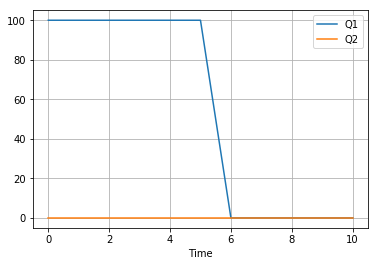

In [59]:
%matplotlib inline

import pandas as pd
data = pd.read_csv('data.csv')
data.index = data['Time']
print(data)
data[['Q1','Q2']].plot(grid=True)

## The TCLab `Plotter`

The `Plotter` class adds a real time plotting of experimental data. A plotter is created from an instance of an historian as follows

    h = Historian(lab.sources)
    p = Plotter(h)
    
Updating the plotter also updates the associated historian.

    p.update(t)
    
The following example shows how this works.

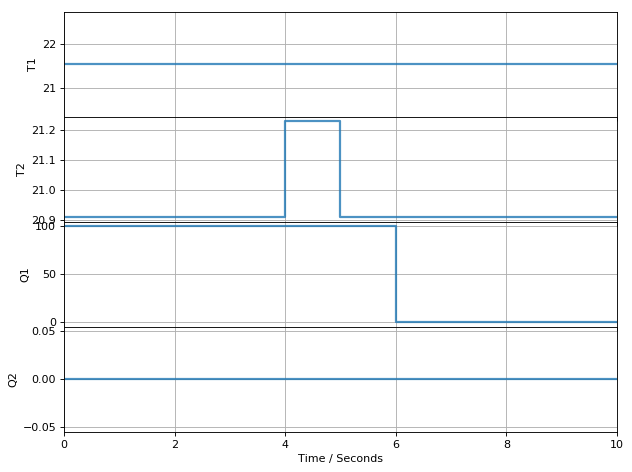

TCLab disconnected successfully.


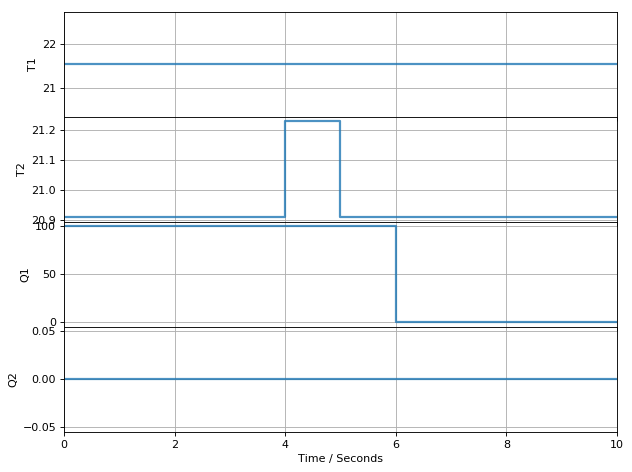

In [63]:
from tclab import TCLab, clock, Historian, Plotter

with TCLab() as lab:
    h = Historian(lab.sources)
    p = Plotter(h, 10)
    for t in clock(10):
        lab.Q1(100 if t <= 5 else 0)
        p.update(t)
        
h.to_csv('data.csv')

## Using TCLab Offline

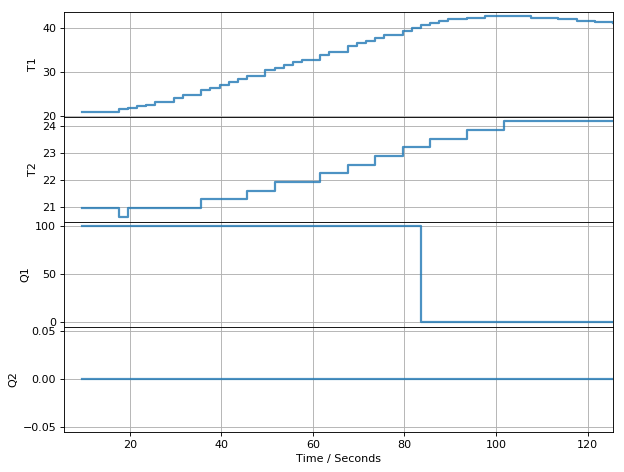

TCLab Model disconnected successfully.


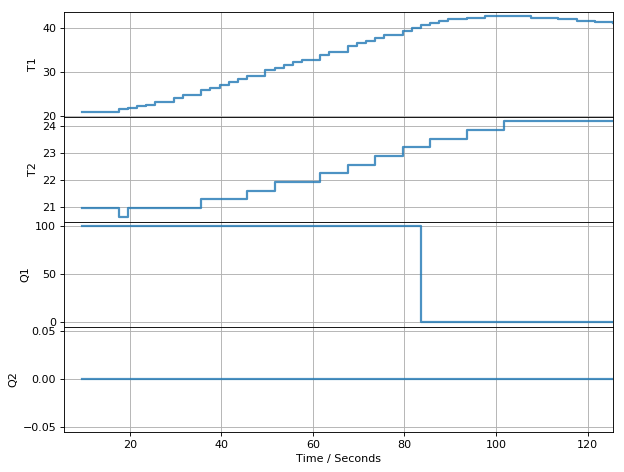

In [3]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=20)

SP = 40
with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(120,2):
        PV = a.T1
        MV = 100 if SP > PV else 0
        a.U1 = MV
        p.update()

## Running Diagnostics

In [7]:
import tclab

print("Version = ", tclab.__version__)
tclab.diagnose()

Version =  0.4.8

Checking connection
-------------------
Looking for Arduino on any port...
--- Serial Ports ---
/dev/cu.JeffreyKantorsAirPods-W-1 n/a n/a
/dev/cu.Bluetooth-Incoming-Port n/a n/a
No known Arduino was found in the ports listed above.
